# **1. INTRODUCTION**
---
**Title**: ***Feedback to Foresight: Simplifying App Review Sentiment Analysis***

**Members** : 
1. Devin Yaung Lee — Data Analyst
2. Fernaldy Aristo Wirjowerdojo — Data Engineer
3. Muhammad Furqon Pakpahan — Data Engineer
4. Sifra Hilda Juliana Siregar — Data Scientist

**Project Overview**:   

This project focuses on performing sentiment analysis on Google Play Store app reviews. Utilizing Natural Language Processing (NLP), the goal is to analyse user feedback to gain insights into satisfaction and app perception

**Background**:
---
**Problem Statement**:  

In the competitive landscape of mobile applications, user feedback for app reviews is a goldmine of insights that can inform product development and marketing strategies. However, these reviews are often unstructured, making it challenging to efficiently extract, categorize, and analyze sentiments and opinions. There is a need for an automated system that can process this feedback to provide actionable insights, identify trends in user sentiment, and highlight areas for improvement. This project aims to address the lack of structured analysis of user-generated content in app reviews on the Google Play Store, which, if leveraged correctly, can significantly enhance user satisfaction and app performance in the market.

**Objectives**: 
- ***Develop an Automated Sentiment Analysis Model:***  
Build and train a TensorFlow model to classify app reviews into positive, negative, and neutral sentiments with high accuracy.

- ***Understand the user feedbacks in depth:***  
Utilize the sentiment analysis model to delve into the nuances of user feedback on the Google Play Store

**Dataset**:  
The dataset used in this project is obtained from Kaggle from [this link](https://www.kaggle.com/datasets/whenamancodes/play-store-apps?select=googleplaystore.csv).

**Project Structure**
---
**Workflow**
***The workflow is split into 3, separated by roles:***
- **Data Engineering:**
  - Data Collection: Raw data is stored in an AWS S3 bucket
  - Data Cleaning: An Apache Airflow DAG is set up to fetch and clean the data
  - Data Storage: Cleaned data is stored back into an S3 bucket

- **Data Science:**
  - Model Development: Using the cleaned data from the S3 bucket, a TensorFlow regression model is created to perform sentiment analysis
  - Model Optimization: Tuning and optimization of the model for better accuracy

- **Data Analysis:**
  - Data Interpretation: Analyze the results from the model to understand user sentiment
  - Visualization: Create visual representations of the analysis for easier interpretation and presentation
  - Reporting: Compile findings and insights into a comprehensive report

# **2. IMPORT LIBRARIES**

In [1]:
import boto3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from preprocessing_function.text_preprocessed import text_preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leede\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **3. LOAD DATA**

In [8]:
warnings.filterwarnings('ignore')

In [7]:
# Path to the credentials file
credentials_file_path = 'aws_credentials/aws_credentials_devin.txt'

# Read the credentials file and set environment variables
with open(credentials_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        os.environ[key] = value

In [8]:
# Create a Boto3 S3 resource
s3 = boto3.resource('s3')

# Download the file
bucket = s3.Bucket('hck-009-group-2')
bucket.download_file('clean_data/data_clean.csv', './data/data_clean.csv')

In [2]:
data = pd.read_csv('data/data_clean.csv')
data

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,coloring book moana,art_and_design,3.9,967,14m,500000,free,0.0,everyone,"['art & design', 'pretend play']",2018-01-15,2.0.0,4.0.3 and up,a kid's excessive ads. the types ads allowed a...,negative,-0.25,1.00
1,coloring book moana,art_and_design,3.9,967,14m,500000,free,0.0,everyone,"['art & design', 'pretend play']",2018-01-15,2.0.0,4.0.3 and up,it bad >:(,negative,-0.72,0.83
2,coloring book moana,art_and_design,3.9,967,14m,500000,free,0.0,everyone,"['art & design', 'pretend play']",2018-01-15,2.0.0,4.0.3 and up,like,neutral,0.00,0.00
3,coloring book moana,art_and_design,3.9,967,14m,500000,free,0.0,everyone,"['art & design', 'pretend play']",2018-01-15,2.0.0,4.0.3 and up,i love colors inspyering,positive,0.50,0.60
4,coloring book moana,art_and_design,3.9,967,14m,500000,free,0.0,everyone,"['art & design', 'pretend play']",2018-01-15,2.0.0,4.0.3 and up,i hate,negative,-0.80,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40311,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,overall great app. best gallery seen far,positive,0.48,0.51
40312,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,"recommended, 100% love it, keep good work dev ...",positive,0.57,0.73
40313,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,too much ads,positive,0.20,0.20
40314,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,just allow time ...,neutral,0.00,0.00


Drop Duplicated Columns

In [3]:
data.columns

Index(['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content_rating', 'genres', 'last_updated', 'current_ver',
       'android_ver', 'translated_review', 'sentiment', 'sentiment_polarity',
       'sentiment_subjectivity'],
      dtype='object')

In [4]:
data = data.drop_duplicates(subset=['app', 'category', 'rating', 'size', 'installs', 'type',
                                    'price', 'content_rating', 'genres', 'last_updated', 'current_ver',
                                    'android_ver', 'translated_review', 'sentiment', 'sentiment_polarity',
                                    'sentiment_subjectivity'], keep='first')

- point of view = consultants
- client = google

client punya dataset yang berisikan sentiment dari seluruh aplikasi yang ada di google play, kami akan membuat model untuk mengetahui sentiment dari seluruh aplikasi di google play

In [5]:
data[(data['rating']>4) & (data['sentiment']== 'negative')]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
44,garden coloring book,art_and_design,4.4,13791,33m,1000000,free,0.0,everyone,['art & design'],2017-09-20,2.9.2,3.0 and up,i really enjoying application. my complaint sm...,negative,-0.03,0.58
45,garden coloring book,art_and_design,4.4,13791,33m,1000000,free,0.0,everyone,['art & design'],2017-09-20,2.9.2,3.0 and up,"people thinks game dumb, ok.but game soo fun ....",negative,-0.01,0.38
46,garden coloring book,art_and_design,4.4,13791,33m,1000000,free,0.0,everyone,['art & design'],2017-09-20,2.9.2,3.0 and up,this work first place. keeps asking permission...,negative,-0.38,0.62
49,garden coloring book,art_and_design,4.4,13791,33m,1000000,free,0.0,everyone,['art & design'],2017-09-20,2.9.2,3.0 and up,this game nice relax mine need buy it.. so ins...,negative,-0.07,0.60
60,garden coloring book,art_and_design,4.4,13791,33m,1000000,free,0.0,everyone,['art & design'],2017-09-20,2.9.2,3.0 and up,easy picture pretty pop-up ads annoying..,negative,-0.04,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40279,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,entire album corrupted opening. i lost friends...,negative,-0.38,0.69
40280,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,apps good add. very bad,negative,-0.10,0.73
40283,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,alert july 28th contains contain virus gone mi...,negative,-0.20,0.05
40291,a+ gallery - photos & videos,photography,4.5,223941,varies with device,10000000,free,0.0,everyone,['photography'],2018-08-06,varies with device,varies with device,world's worst photo gallery.,negative,-1.00,1.00


# **4. EXPLORATORY DATA ANALYSIS (EDA)**

## ***4.1. Data Explore***

- **4.1.1 Data Information**

In [6]:
# Display Info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30117 entries, 0 to 40315
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app                     30117 non-null  object 
 1   category                30117 non-null  object 
 2   rating                  30117 non-null  float64
 3   reviews                 30117 non-null  int64  
 4   size                    30117 non-null  object 
 5   installs                30117 non-null  int64  
 6   type                    30117 non-null  object 
 7   price                   30117 non-null  float64
 8   content_rating          30117 non-null  object 
 9   genres                  30117 non-null  object 
 10  last_updated            30117 non-null  object 
 11  current_ver             30117 non-null  object 
 12  android_ver             30117 non-null  object 
 13  translated_review       30117 non-null  object 
 14  sentiment               30117 non-null  obj

- **4.1.2 Data Shape**

In [9]:
# Checking Data Shape
data.shape

(30117, 17)

- **4.1.3 Missing Value**

In [10]:
# Checking Missing Value
data.isnull().sum()

app                       0
category                  0
rating                    0
reviews                   0
size                      0
installs                  0
type                      0
price                     0
content_rating            0
genres                    0
last_updated              0
current_ver               0
android_ver               0
translated_review         0
sentiment                 0
sentiment_polarity        0
sentiment_subjectivity    0
dtype: int64

## ***4.2. Descriptive Statistics Analysis***

**4.2.1 Data Summary**

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,30117.0,4.297304e+00,3.052101e-01,2.6,4.10,4.30,4.50,4.900000e+00
reviews,30117.0,1.423388e+06,6.179188e+06,46.0,9971.00,59158.00,399009.00,7.815831e+07
installs,30117.0,3.718110e+07,1.347455e+08,1000.0,1000000.00,5000000.00,10000000.00,1.000000e+09
price,30117.0,9.730285e-02,1.302302e+00,0.0,0.00,0.00,0.00,2.999000e+01
sentiment_polarity,30117.0,1.839629e-01,3.531091e-01,-1.0,0.00,0.15,0.41,1.000000e+00
sentiment_subjectivity,30117.0,4.928844e-01,2.615483e-01,0.0,0.36,0.51,0.65,1.000000e+00


**Rating**:
- Most apps have a good rating, around 4.32 on average.
- Ratings go from 2.6 to 4.9, with many falling between 4.2 and 4.5.

**Reviews**:
- Apps have a wide range of reviews, from a few dozen to millions.
- On average, an app has about 2.2 million reviews.
- The middle range is from 17,000 to 1.5 million reviews.

**Installs**:
- Apps are installed a lot, with an average of 59 million installs.
- Install numbers vary, from 1,000 to a billion.
- Many apps fall between 1 million and 50 million installs.

**Price**:
- Most apps are free; the average price is only 8 cents.
- Prices range from free to $29.99.
  
**Sentiment Polarity**:
- On average, people express a slightly positive sentiment (feeling) about apps.
- Sentiment ranges from strongly negative to strongly positive.
  
**Sentiment Subjectivity**:
- People express a balanced mix of objective and subjective feelings about apps.
- Subjectivity ranges from completely objective to completely subjective.

In [8]:
# Checking kurtosis
kurt = data.kurt(numeric_only=True)
kurt

rating                      3.158545
reviews                   106.412895
installs                   40.958762
price                     383.975627
sentiment_polarity          0.646310
sentiment_subjectivity     -0.310063
dtype: float64

**Kurtosis:**

**Rating** (3.677492):
- Ratings have some extreme values, both very high and very low.

**Reviews** (69.726271):
- Some apps have a lot more reviews than others, making the distribution more peaked.

**Installs** (22.547344):
- A few apps have a significantly higher number of installs, making the distribution more peaked.

**Price** (503.693728):
- Some apps have very high prices, causing the distribution to have extremely heavy tails.

**Sentiment Polarity** (0.753633):
- There are some apps with extremely positive or extremely negative sentiment, making the distribution more peaked.

**Sentiment Subjectivity** (-0.124254):
- The sentiment subjectivity values are spread out, not concentrated around a central value.

In [9]:
# Checking Skewness
skew = data.skew(numeric_only=True)
skew

rating                    -1.307910
reviews                    9.500859
installs                   6.300785
price                     18.319211
sentiment_polarity        -0.121698
sentiment_subjectivity    -0.303908
dtype: float64

**Skewness:**

**Rating** (-1.391847):
- More apps tend to have higher ratings, and fewer have lower ratings.

**Reviews** (7.643747):
- A few apps have a lot of reviews, pulling the distribution towards higher values.
  
**Installs** (4.754725):
- Some apps have significantly more installs than others, making the distribution right-skewed.
  
**Price** (20.887272):
- A few apps have very high prices, causing the distribution to be right-skewed.
  
**Sentiment Polarity** (-0.070451):
- Slightly more apps may have negative sentiment than positive sentiment.

**Sentiment Subjectivity** (-0.318551):
- More apps tend to have lower sentiment subjectivity, indicating more objectivity in sentiments.

**4.2.2 VIF Analysis**

In [10]:
# membuat function untuk menghitung nilai VIF
X_num = data.select_dtypes(include=np.number)

def calc_vif(X_num):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X_num.columns
    vif["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

    return(vif)

calc_vif(X_num)

,variables,VIF
0,rating,4.670482
1,reviews,1.633637
2,installs,1.662538
3,price,1.006292
4,sentiment_polarity,1.376541
5,sentiment_subjectivity,4.873637


*Explanation:*
- Rating: The VIF for rating is **5.070138**, which is moderately high. This suggests that the rating variable has some multicollinearity with the other variables in the regression model, but it's typically not high enough to cause major concerns, as a common rule of thumb is that a VIF greater than 10 indicates high multicollinearity.

- Reviews: The VIF of **1.597357** for reviews is quite low, suggesting that this variable does not have much multicollinearity with the other variables in the model.

- Installs: With a VIF of **1.629610**, installs also shows a low level of multicollinearity. It is not highly dependent on the other variables in the regression model.

- Price: The price has a VIF of **1.005481**, which is very low. This implies that there is almost no multicollinearity between price and the other variables in the model.

- Sentiment_polarity: The VIF for sentiment_polarity is **1.329355**, indicating low multicollinearity. It has a relatively independent relationship with the other variables.

- Sentiment_subjectivity: The sentiment_subjectivity variable has a VIF of **5.201740**. Similar to rating, it shows a moderate level of multicollinearity, which may suggest a need for further investigation but is not typically concerning unless the VIF is greater than 10.

Overall, the VIF values in this table suggest that while there is some multicollinearity present in the variables rating and sentiment_subjectivity, it might not be severe enough to distort the regression model. However, it is important to consider these VIF values in the context of the specific model and data being used.

## **4.3 Phik Correlation**

In [12]:
# Defining list features
attributes = data.select_dtypes(include=np.number).columns.tolist()

# Making sure 'sentiment' column is treated as an interval variable, if it is numeric.
interval_cols = ['sentiment'] if 'sentiment' in attributes else []

# Calculating the phik matrix for analyzing feature correlations
phik_overview = data[attributes].phik_matrix(interval_cols=interval_cols)

# Function to categorize correlation
def categorize_correlation(phik_value):
    if phik_value > 0.5:
        return 'High_Positive_Correlation'
    elif phik_value > 0.1:
        return 'Moderate_Positive_Correlation'
    else:  # <= 0.1
        return 'Low_Positive_Correlation'
    
# DataFrame for categorical correlations
correlation_df = phik_overview.applymap(categorize_correlation)
correlation_df


C:\Users\leede\AppData\Local\Temp\ipykernel_30684\432692018.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  correlation_df = phik_overview.applymap(categorize_correlation)


,rating,reviews,installs,price,sentiment_polarity,sentiment_subjectivity
rating,High_Positive_Correlation,High_Positive_Correlation,Moderate_Positive_Correlation,Moderate_Positive_Correlation,Moderate_Positive_Correlation,Moderate_Positive_Correlation
reviews,High_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,Moderate_Positive_Correlation
installs,Moderate_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,Moderate_Positive_Correlation,Moderate_Positive_Correlation
price,Moderate_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation,Low_Positive_Correlation,Low_Positive_Correlation
sentiment_polarity,Moderate_Positive_Correlation,High_Positive_Correlation,Moderate_Positive_Correlation,Low_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation
sentiment_subjectivity,Moderate_Positive_Correlation,Moderate_Positive_Correlation,Moderate_Positive_Correlation,Low_Positive_Correlation,High_Positive_Correlation,High_Positive_Correlation


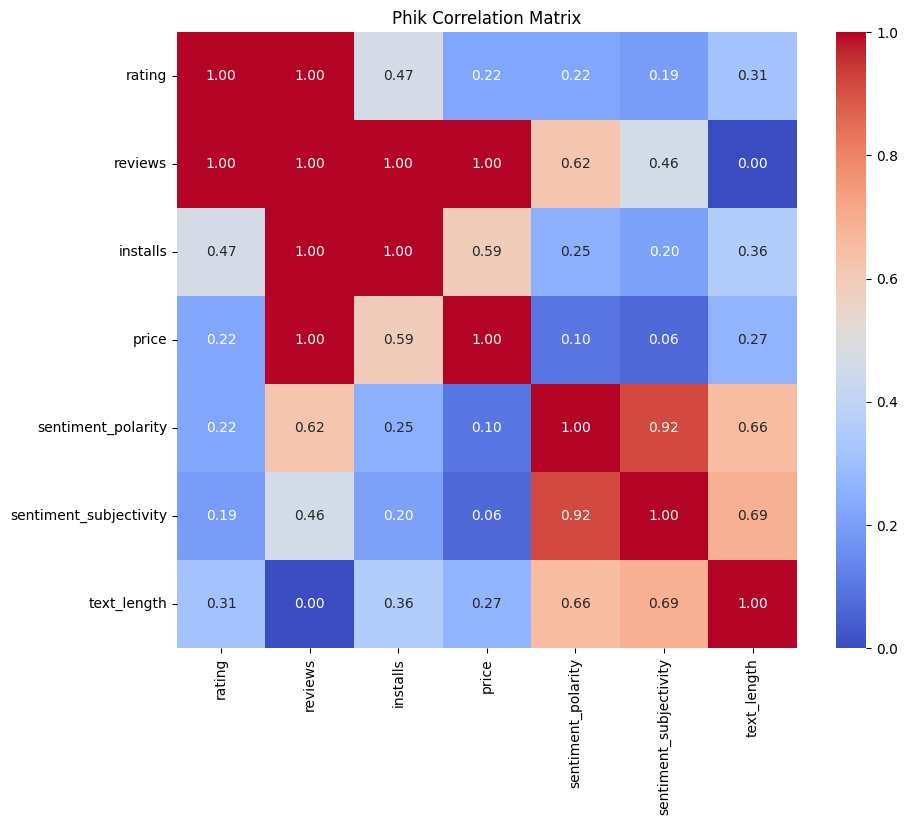

In [32]:
# Your provided code, assuming 'data' is defined and valid
attributes = data.select_dtypes(include=np.number).columns.tolist()
interval_cols = ['sentiment'] if 'sentiment' in attributes else []
phik_overview = data[attributes].phik_matrix(interval_cols=interval_cols)

# Creating a DataFrame for the actual 'phik_overview' from your data
phik_overview_df = pd.DataFrame(phik_overview, columns=attributes, index=attributes)

# Visualizing the phik correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(phik_overview_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()

***Explanation:***  

**Sentiment Polarity**
- **Correlation with Reviews (0.62):** Indicates a notable relationship between the number of reviews and sentiment polarity.
- **Correlation with Text Length (0.66):** Suggests that longer reviews tend to have a more defined sentiment polarity.

**Sentiment Subjectivity**
- **Correlation with Reviews (0.46):** Shows a moderate relationship, indicating that the subjectivity of sentiment in reviews is less influenced by the number of reviews.
- **Correlation with Text Length (0.69):** Indicates that longer reviews are often more subjective.

## **4.4 Rating Distribution**

C:\Users\leede\AppData\Local\Temp\ipykernel_30684\3599755659.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_count.index, y=rating_count.values, palette="viridis")


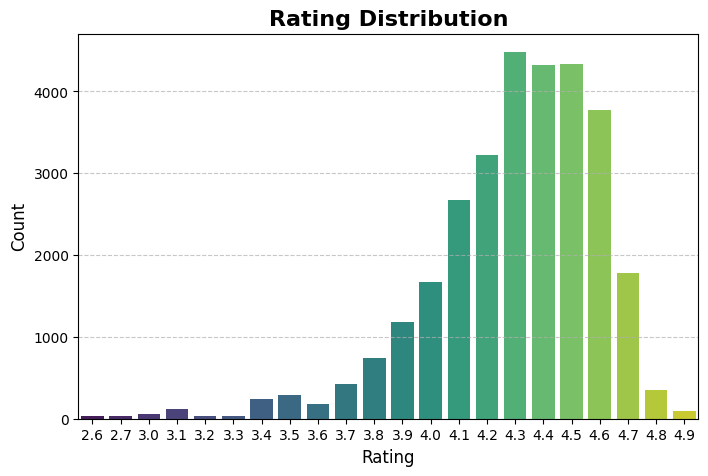

In [21]:
rating_count = data['rating'].value_counts()
# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_count.index, y=rating_count.values, palette="viridis")
plt.title('Rating Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

*Explanation:*  
From this Histogram of Rating Distribution, we know:

- The distribution is skewed towards higher ratings, with most apps receiving ratings between 4.0 and 4.7.
- The highest frequency of ratings is at 4.4, followed closely by 4.3 and 4.5, indicating that a large number of apps are rated favorably.
- Very few apps have ratings lower than 3.0, suggesting either a selection of generally well-received apps or a tendency for users to rate apps more favorably.
  
The drop in frequency for ratings 4.8 and above could indicate a standard where few apps are rated as near-perfect.
Overall, this distribution indicates a trend where users rate apps positively, with few instances of very low ratings.

## **4.5 Review Distribution**

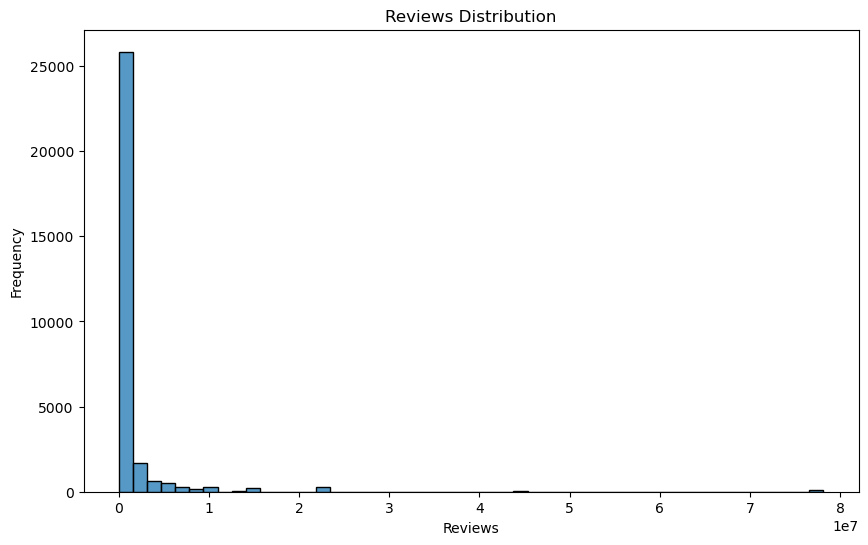

In [17]:
# Reviews Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['reviews'], bins=50, kde=False)
plt.title('Reviews Distribution')
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.show()

*Explanation:*  
- The distribution is highly right-skewed, indicating that a large number of apps have a small number of reviews, This could be due to several reasons like new apps, or even unpopular apps, while only a few apps have a very high number of reviews. This pattern suggests that a small subset of apps is receiving the majority of the attention from users in terms of reviews.

## **4.6 Price Distribution Among Paid Apps**

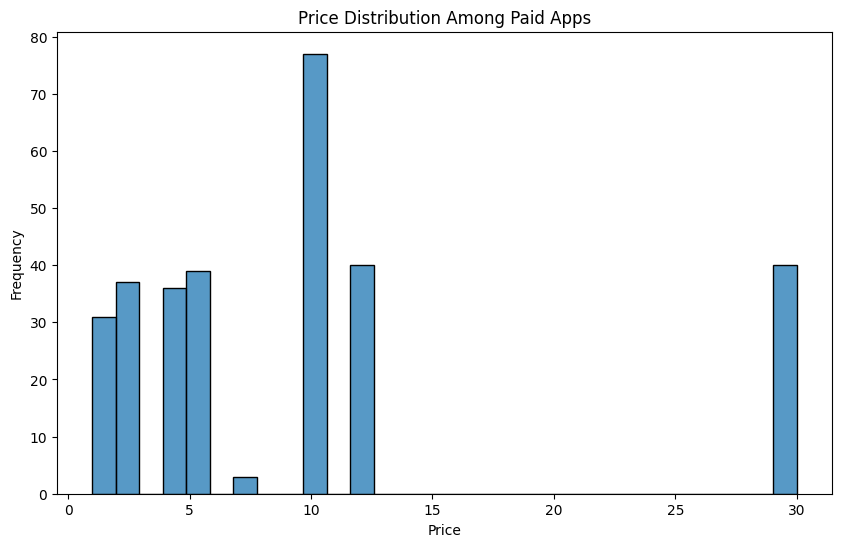

In [23]:
# Price Distribution Among Paid Apps
plt.figure(figsize=(10, 6))
sns.histplot(data[data['price'] > 0]['price'], bins=30, kde=False)
plt.title('Price Distribution Among Paid Apps')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

*Explanation:*  
- Most paid apps are priced below $10, with peaks at around the $2 and $4 price points. There are fewer apps at higher price points, indicating that lower-priced apps are more common and potentially more popular among users.

## **4.7 Rating vs Reviews**

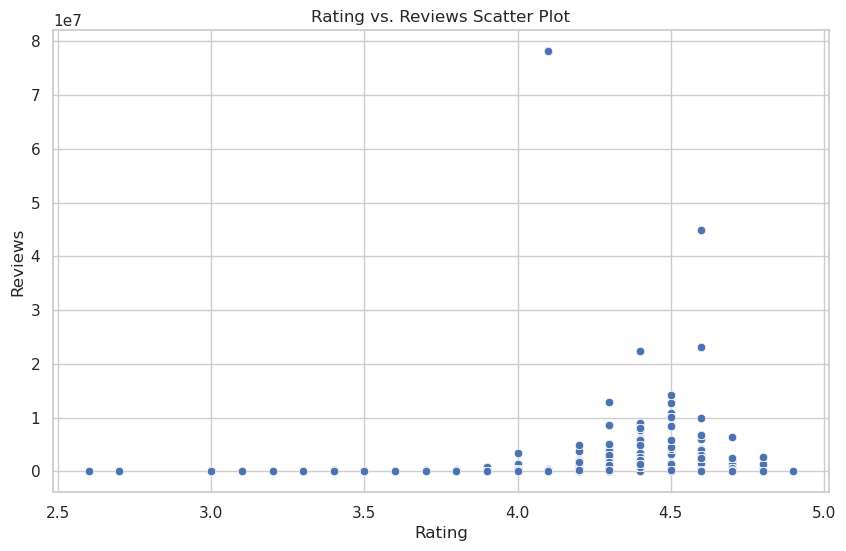

In [23]:
# Rating vs. Reviews Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='reviews', data=data)
plt.title('Rating vs. Reviews Scatter Plot')
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.show()

***Explanation:***  
- here is a concentration of apps with high ratings and a moderate number of reviews. Very few apps have low ratings, and apps with a very high number of reviews are relatively rare. This may indicate that well-rated apps tend to receive a good number of reviews, but not all popular apps (in terms of the number of reviews) are necessarily high-rated.

## **4.8 Category Popularity**

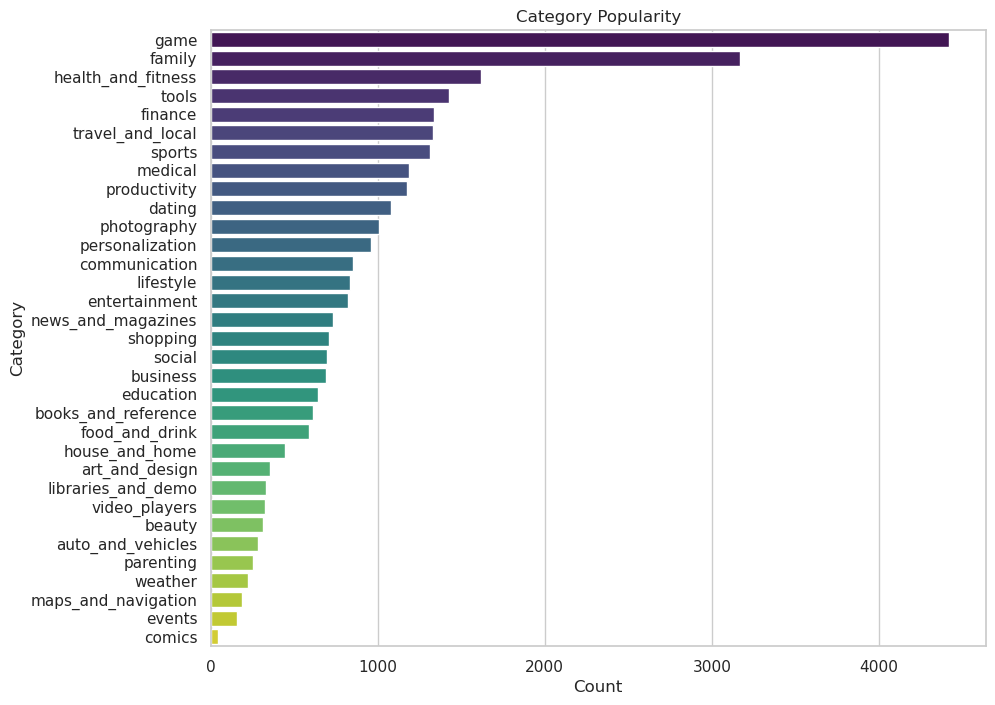

In [24]:
# Category Popularity
plt.figure(figsize=(10, 8))
sns.countplot(y='category', data=data, order=data['category'].value_counts().index, palette='viridis')
plt.title('Category Popularity')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

*Explanation:*  
- The 'Game' category is the most populated, followed by 'Family' and 'Health & Fitness', suggesting these are the most common types of apps. Less populated categories like 'Events' and 'Comics' may represent niche markets.

## **4.9 Boxplot of Ratings by Category**

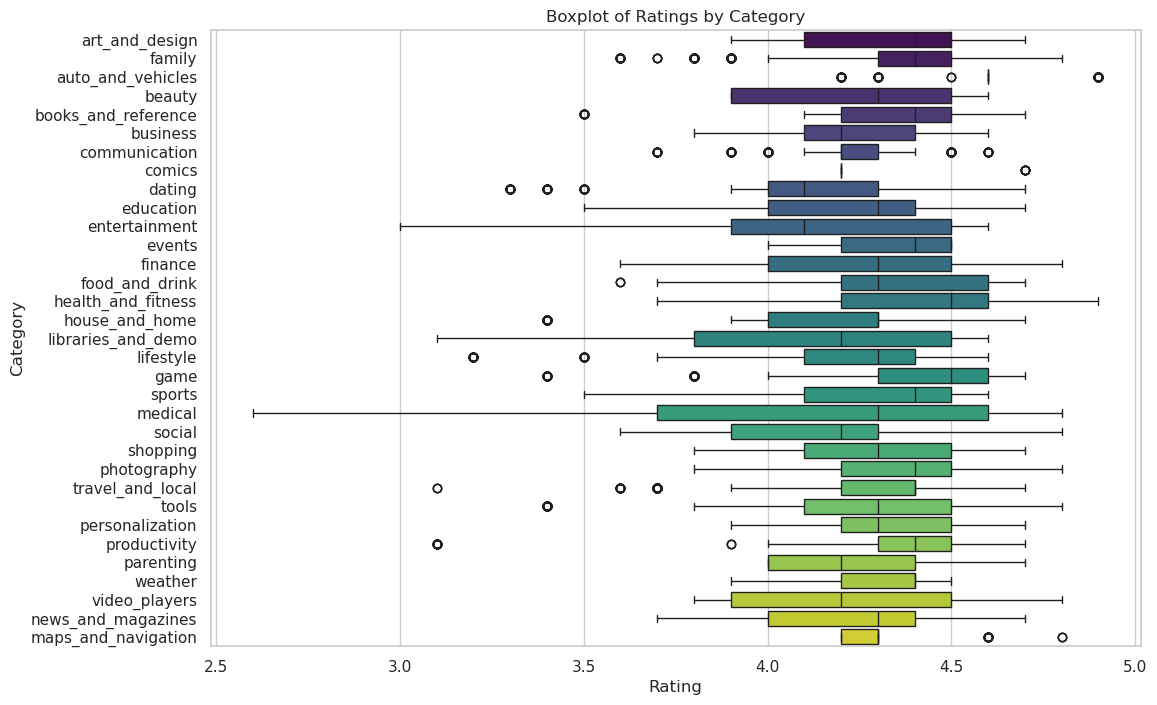

In [25]:
# Boxplot of Ratings by Category
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='category', data=data, orient='h', palette="viridis")
plt.title('Boxplot of Ratings by Category')
plt.xlabel('Rating')
plt.ylabel('Category')
plt.show()

From the boxplot, we can deduce:

- Most categories have median ratings above 4.0, indicating generally positive reception of apps across all categories.
- Some categories show a wide range of ratings (evidenced by longer boxes), indicating more variability in how users rate these apps.
- Categories with tight boxes, where Q1 and Q3 are close together, indicate more consistency in ratings.
- Outliers are present in many categories, both on the high and low ends, suggesting that there are a few apps that are rated significantly 
differently than the majority in their category.

Overall, this plot provides a comprehensive view of how apps are rated within each category, showing general user satisfaction and highlighting categories with more diverse user opinions

## **4.10 Sentiment Distribution**

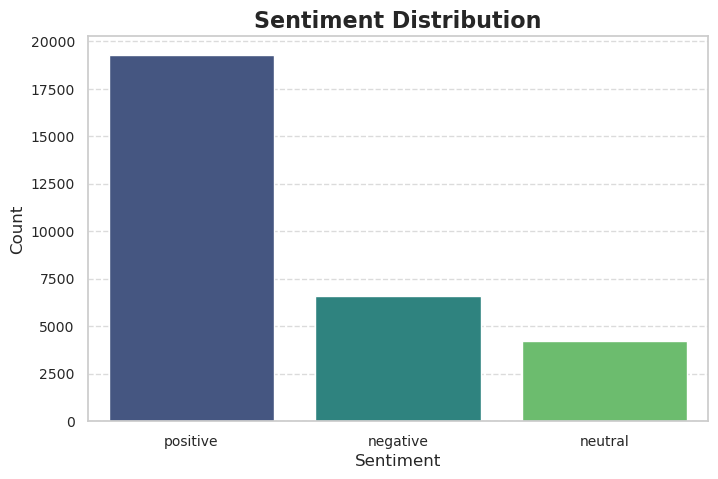

In [26]:
# Sentiment distribution
sentiment_count = data['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette="viridis")
plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

*Explanation:*  
- Based on the Sentiment Distribution Bar Chart, The 'positive' category has the highest count, exceeding 20,000 items. The 'negative' category has a lower count, roughly around 7,500 items. The 'neutral' category has the least, with just under 5,000 items. This suggests that the positive sentiment among the items being analyzed predominates significantly over negative and neutral sentiments.

## **4.11 Sentiment Polarity Analysis**

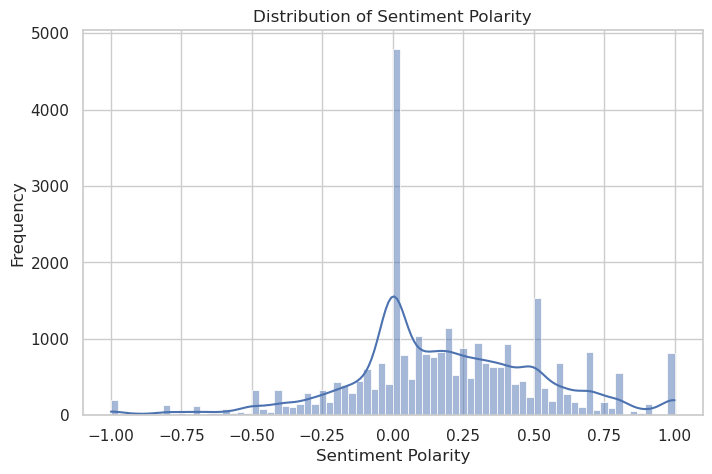

In [29]:
# Plotting
plt.figure(figsize=(8, 5))
sns.histplot(data['sentiment_polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

*Explanation:*  
- The chart shows a large concentration of scores around 0, indicating a high frequency of neutral sentiments. There is a notable spike at exactly 0, which is significantly higher than any other value, suggesting a large number of entries with a perfectly neutral sentiment. The distribution is somewhat bimodal, with smaller peaks in the positive range (around 0.5) and negative range (around -0.25 to -0.5), implying clusters of positive and negative sentiments as well. However, the positive sentiments appear to have a slightly wider spread with multiple smaller peaks, while negative sentiments are more concentrated around their peak.Overall, this suggests that the data contains a high volume of neutral sentiments, with a presence of both positive and negative sentiments, and a broader diversity of positive sentiment intensities.

## **4.12 Sentiment Subjectivity Analysis**

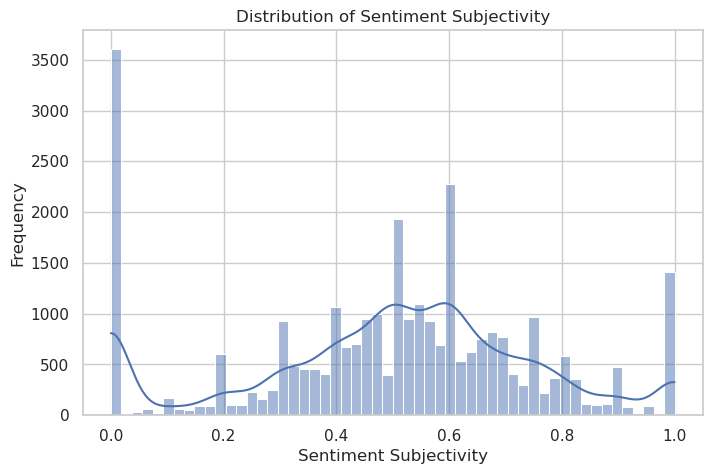

In [28]:
# Plotting
plt.figure(figsize=(8, 5))
sns.histplot(data['sentiment_subjectivity'], kde=True)
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Frequency')
plt.show()

*Explanation:*
From the histogram of sentiment subjectivity, we know:  
- A high peak at 0, suggesting a significant number of texts are classified with no subjectivity, meaning they are likely to be factual or objective.
- Several moderate peaks throughout, especially noticeable around 0.2, 0.5, 0.6, and towards the higher end at 1.0.
- The peaks at 0.5 and higher indicate a considerable number of texts contain subjective opinions.

The distribution is somewhat uneven, suggesting varying levels of opinion across the dataset, with a notable amount of completely objective (or detected as such) texts and others expressing different degrees of subjectivity. The presence of multiple peaks indicates that texts do not conform to a single level of subjectivity but vary widely, which might be typical in datasets containing both factual information and personal opinions

## **4.13 Text Analysis**

In [27]:
#check text length
len(data['translated_review'])

30117

*Explanation:*  
There are 40316 individual text items in the data.

### **Word Frequency**

In [10]:
# Check word frequency
words = [word for text in data['translated_review'].dropna() for word in word_tokenize(text.lower())]

# Frequency distribution
word_freq = FreqDist(words)

# 10 most common words
print(word_freq.most_common(10))

[('.', 74147), ('i', 44312), (',', 31283), ('!', 15659), ('game', 13536), ('it', 12954), ('the', 6754), ('like', 6321), ("'s", 6273), ('get', 5792)]


### **Stop Words & Lemmatizer**

In [11]:
# Stop words 
stop_words = set(stopwords.words('english'))

# Lemmatizer
lemmatizer = WordNetLemmatizer()

In [12]:
# Pre-process text for the model
data['text_processed'] = data['translated_review'].apply(lambda x: text_preprocessing(x, lemmatizer, stop_words))
data.sample(5)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,text_processed
2319,cisco webex meetings,business,4.4,108741,28m,10000000,free,0.0,everyone,['business'],2018-07-20,11.1.0,4.3 and up,easy get meetings started. sometimes little cl...,positive,0.32,0.64,easy get meeting started sometimes little clun...
16121,8 ball pool,game,4.5,14201891,52m,100000000,free,0.0,everyone,['sports'],2018-07-31,4.0.0,4.0.3 and up,sir new update awesome u solve issues issue pl...,positive,0.41,0.51,sir new update awesome u solve issue issue pla...
11044,calorie counter - macros,health_and_fitness,4.0,3061,5.5m,100000,free,0.0,everyone,['health & fitness'],2016-08-27,2.3.4,5.0 and up,love tracking macros!! not find common foods d...,positive,0.49,0.70,love tracking macro find common food database ...
19896,episode - choose your story,family,4.3,1842381,varies with device,50000000,free,0.0,teen,['simulation'],2018-07-31,varies with device,varies with device,every time i try open load! 4 hrs get passes!!...,positive,0.08,0.46,every time try open load hr get pass everytime...
31070,booking.com travel deals,travel_and_local,4.7,1830387,varies with device,100000000,free,0.0,everyone,['travel & local'],2018-08-06,varies with device,varies with device,not good offer there's better offer price i bo...,positive,0.08,0.55,good offer 's better offer price booking year ...


### **Sentiment Labeling**

In [13]:
# Integer labeling for the sentiments
def change_sentiment(value):
    if value == "negative":
        return 1
    elif value == "positive":
        return 2
    else:
        return 0

data['label'] = data['sentiment'].map(change_sentiment)
data.sample(5)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,text_processed,label
29442,free sports tv,sports,4.3,1802,9.8m,100000,free,0.0,everyone,['sports'],2018-06-21,1.4,4.0.3 and up,i really love advent useless,neutral,0.00,0.40,really love advent useless,0
13353,bubble shooter,game,4.5,148897,46m,10000000,free,0.0,everyone,['casual'],2018-07-17,1.20.1,4.0.3 and up,my free work time never uploads new video plz ...,positive,0.25,0.48,free work time never uploads new video plz loo...,2
7828,google pay,finance,4.2,347874,varies with device,100000000,free,0.0,everyone,['finance'],2018-07-26,2.70.206190089,varies with device,convenient easy stores inside apps. this works...,negative,-0.02,0.64,convenient easy store inside apps work well cr...,1
5092,ferzu - furries social network,dating,3.9,1576,varies with device,10000,free,0.0,mature 17+,['dating'],2018-02-16,4.4.1,4.1 and up,the super buggy needs fixed bugs see 10 first ...,positive,0.22,0.32,super buggy need fixed bug see first message s...,2
25230,ada - your health guide,medical,4.7,87418,14m,1000000,free,0.0,everyone,['medical'],2018-07-16,2.25.0,4.4 and up,this is cool it gives you access to what may b...,positive,0.09,0.64,cool give access may wrong health pretty cool ten,2


### **Length Distribution for each Sentiment**

In [25]:
# Length Distribution for each Sentiment
data['text_length'] = data['translated_review'].apply(len)
data['text_length'].describe()

C:\Users\leede\AppData\Local\Temp\ipykernel_30684\421449861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_length'] = data['translated_review'].apply(len)


count    30117.000000
mean       109.937776
std        103.804984
min          2.000000
25%         32.000000
50%         83.000000
75%        158.000000
max       2713.000000
Name: text_length, dtype: float64

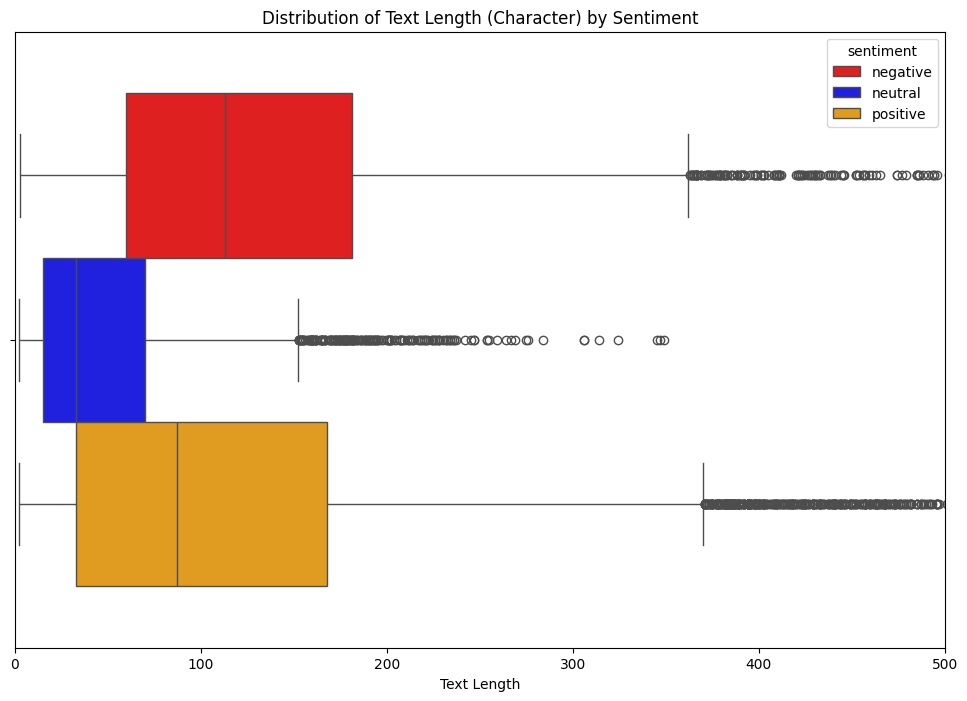

In [26]:
# Display Boxplot of Text Length
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='text_length', hue='sentiment', palette={'positive': 'orange', 'neutral': 'blue', 'negative': 'red'})
plt.xlim(0, 500)
plt.xlabel('Text Length')
plt.title('Distribution of Text Length (Character) by Sentiment')
plt.show()


### **Wordcloud**

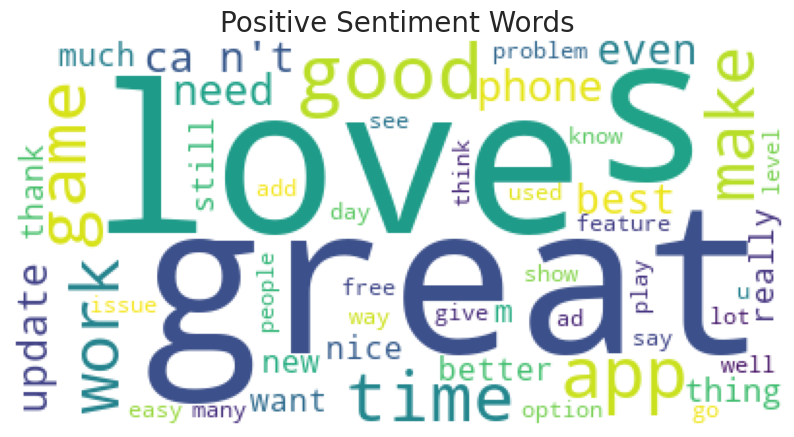

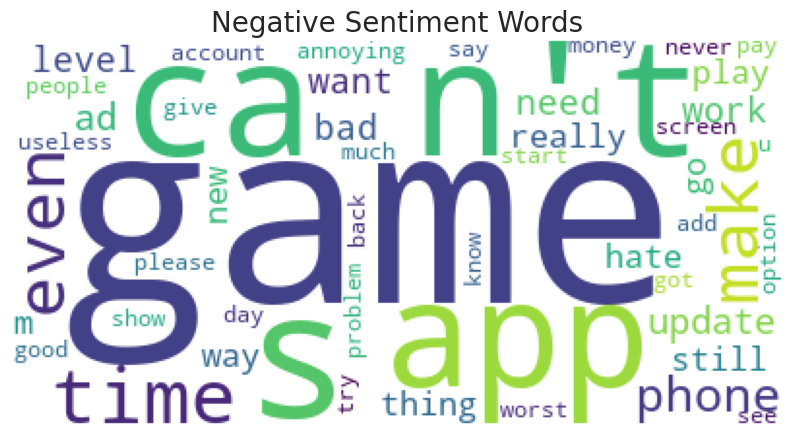

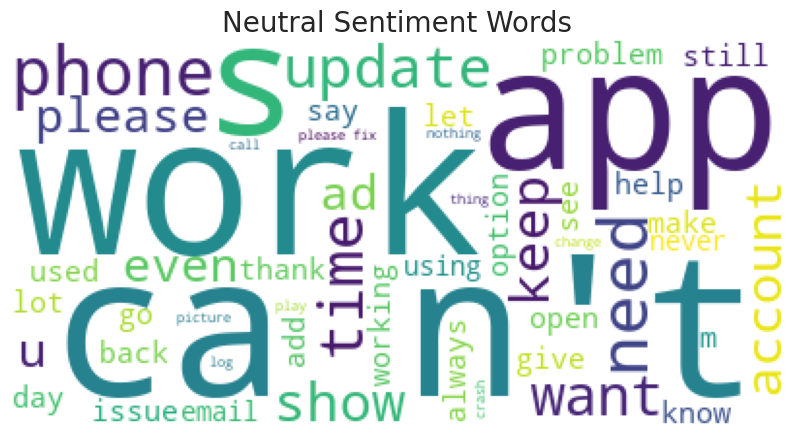

In [65]:
def wordcount_gen(data, label):
    combined_reviews = " ".join([text for text in data[data.label==label]['text_processed']])
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)
    if label == 2:
        sentiment = 'Positive'
    elif label == 1:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_reviews))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive
wordcount_gen(data, 2)

# Negative
wordcount_gen(data, 1)

# Neutral
wordcount_gen(data, 0)

# **Conclusion EDA:**  

***Rating Distribution***: 
- The majority of apps have high ratings, predominantly between 4.0 and 4.7, with 4.4 being the most common. This suggests users are generally satisfied with the apps they use or that there is a positive skew in the way users rate apps.

***Reviews Distribution***: 
- The distribution of reviews is highly skewed towards the lower end, meaning most apps have a relatively small number of reviews, while a few have very large numbers. This is typical in app markets where a small number of popular apps dominate.

***Price Distribution Among Paid Apps***: 
- Most paid apps are priced below $10, with peaks at around the $2 and $4 price points. There are fewer apps at higher price points, indicating that lower-priced apps are more common and potentially more popular among users.

***Rating vs. Reviews Scatter Plot***: 
- There is a concentration of apps with high ratings and a moderate number of reviews. Very few apps have low ratings, and apps with a very high number of reviews are relatively rare. This may indicate that well-rated apps tend to receive a good number of reviews, but not all popular apps (in terms of the number of reviews) are necessarily high-rated.

***Category Popularity***: 
- The 'Game' category is the most populated, followed by 'Family' and 'Health & Fitness', suggesting these are the most common types of apps. Less populated categories like 'Events' and 'Comics' may represent niche markets.

***Boxplot Rating by Category*** : 
- the boxplot demonstrates that apps are generally well-received across various categories with most median ratings above 4.0. Categories with wider boxes suggest a greater disparity in user ratings, while those with narrower boxes indicate more consistent ratings. The presence of outliers shows that there are exceptions where apps receive ratings that greatly differ from the norm within their category. Overall, this visualization underscores a predominantly positive user experience with noticeable variations in some categories.

***Sentiment Distribution***: 
- Positive sentiments are significantly more common than negative or neutral ones, which could indicate either a genuinely positive user experience or a tendency to leave feedback when satisfied rather than dissatisfied.

***Distribution of Sentiment Polarity***: 
- The multi-modal distribution shows that while many reviews are neutral (polarity around 0), there are also noticeable amounts of positive (polarity > 0) and negative (polarity < 0) reviews. The presence of sharp peaks at specific polarities may suggest common sentiment patterns among users.

***Distribution of Sentiment Subjectivity***: 
- The distribution is quite uniform with multiple peaks, indicating that the dataset contains a mix of opinions and factual information. There is a notable number of entries with high subjectivity, signifying personal opinions, and a significant number with low subjectivity, indicating objective statements.

***Text Length by Sentiment***: 
- The distribution of text length for reviews shows that neutral sentiment texts are generally shorter, with a mean length of around 7 words and a median of 5 words. Positive sentiment texts are longer, with a mean of approximately 19 words and a median of 17 words, while negative sentiment texts have a mean length close to 17 words and a median of 14 words. This could indicate that users tend to be more verbose when expressing positive or negative sentiments, while neutral comments are more concise.

***Word Clouds***: 
- The word clouds for positive, negative, and neutral sentiments highlight the most frequently used words in each category. For positive sentiments, words like "love," "great," "good," and "best" dominate, reflecting strong satisfaction. Negative sentiment texts frequently include words like "bad," "problem," "worst," and "annoying," pointing to dissatisfaction. Neutral sentiment texts feature words like "update," "phone," and "app," which may relate to more factual or inquiry-based content rather than opinion.

In summary, the dataset indicates a positive user interaction with apps, with a tendency towards higher ratings and positive sentiments. The reviews are highly skewed, suggesting that a small subset of apps garners most user feedback. Price distribution for paid apps shows a preference for lower-priced options, and app categories reveal a strong preference for games and family-oriented apps. Sentiment analysis reveals a tendency for reviews to express moderate to strong opinions, with a significant presence of neutral sentiment reflecting factual statements.

# **5. FEATURE ENGINEERING**

### Split Data

In [18]:
# data splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(data.text_processed,
                                                            data.label,
                                                            test_size=0.15,
                                                            random_state=20,
                                                            stratify=data.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (30841,)
Val Size   :  (3427,)
Test Size  :  (6048,)


#### Vectorization

In [67]:
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((23039, 15323), (4518, 15323))

In [68]:
# Vocab and sentence length
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  15323
Maximum Sentence Length :  320 tokens


In [69]:
# text vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))
text_vectorization.adapt(X_train)

2023-12-04 22:17:43.287043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 22:17:43.731251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 22:17:43.731415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 22:17:43.733890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 22:17:43.733967: I tensorflow/compile

In [70]:
# Top 20 tokens
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'game',
 'like',
 's',
 'time',
 'good',
 'get',
 'app',
 'great',
 'love',
 'nt',
 'work',
 'would',
 'ad',
 'really',
 'update',
 'even',
 'make',
 'ca']

#### Embedding

In [71]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)
# embedding

#### Results

In [72]:
## Document example
print('Document example')
print(data.text_processed[1])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([data.text_processed[0]]))
print('Vector size : ', text_vectorization([data.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([data.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([data.text_processed[0]])).shape)

Document example
bad

Result of  Text Vectorization
tf.Tensor(
[[ 324    4 3095   14  369   14 1205    8   93 1326  324    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

# **6. MODEL DEFINITION**

In [73]:
# Global seed
seed = 2
np.random.seed(2)
tf.random.set_seed(2)

#### LSTM

In [86]:
tf.keras.backend.clear_session()

model_lstm_reg = Sequential([
    text_vectorization,
    embedding,
    Bidirectional(LSTM(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.3),
    Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.5),
    Dense(1, activation='linear')
], name='LSTM')
model_lstm_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Model summary
model_lstm_reg.summary()

# Model checkpoint
lstm_checkpoint = ModelCheckpoint('lstm', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 320)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 320, 128)          1961344   
                                                                 
 bidirectional (Bidirection  (None, 320, 512)          788480    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 320, 512)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 320, 256)          656384    
 onal)                                                           
                                                              

#### CNN

In [82]:
tf.keras.backend.clear_session()

model_cnn_reg = Sequential([
    text_vectorization,
    embedding,
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=4, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='linear')
], name='CNN')
model_cnn_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Model summary
model_cnn_reg.summary()

# Model checkpoint
cnn_checkpoint = ModelCheckpoint('cnn', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 320)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 320, 128)          1961344   
                                                                 
 conv1d (Conv1D)             (None, 320, 256)          98560     
                                                                 
 max_pooling1d (MaxPooling1  (None, 160, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 160, 128)          131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 80, 128)           0       

#### GRU

In [88]:
tf.keras.backend.clear_session()

model_gru_reg = Sequential([
    text_vectorization,
    embedding,
    Bidirectional(GRU(256, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.3),
    Bidirectional(GRU(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.3),
    Bidirectional(GRU(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))),
    Dropout(0.5),
    Dense(1, activation='linear')
], name='GRU')
model_gru_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Model summary
model_gru_reg.summary()

# Model checkpoint
gru_checkpoint = ModelCheckpoint('gru', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 320)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 320, 128)          1961344   
                                                                 
 bidirectional (Bidirection  (None, 320, 512)          592896    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 320, 512)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 320, 256)          493056    
 onal)                                                           
                                                               

# **7. MODEL TRAINING**

In [79]:
# Early stopping
es = EarlyStopping(monitor='val_mean_absolute_error', patience=25, verbose=1, restore_best_weights=True)

# Reduce Learning Rate
rlr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=5, verbose=1, min_lr=0.00001)

#### LSTM

In [87]:
%%time
lstm_result = model_lstm_reg.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64,
    validation_data=(X_val, y_val), 
    callbacks=[lstm_checkpoint, es, rlr]
)

Epoch 1/50


360/360 [==============================] - ETA: 0s - loss: 0.1246 - mean_absolute_error: 0.2458
Epoch 1: val_mean_absolute_error improved from inf to 0.20111, saving model to lstm
INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 171s 450ms/step - loss: 0.1246 - mean_absolute_error: 0.2458 - val_loss: 0.1687 - val_mean_absolute_error: 0.2011 - lr: 0.0010
Epoch 2/50
360/360 [==============================] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.1668
Epoch 2: val_mean_absolute_error did not improve from 0.20111
360/360 [==============================] - 136s 377ms/step - loss: 0.0589 - mean_absolute_error: 0.1668 - val_loss: 0.2279 - val_mean_absolute_error: 0.3660 - lr: 0.0010
Epoch 3/50
360/360 [==============================] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.1637
Epoch 3: val_mean_absolute_error improved from 0.20111 to 0.17371, saving model to lstm
INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 164s 456ms/step - loss: 0.0560 - mean_absolute_error: 0.1637 - val_loss: 0.1683 - val_mean_absolute_error: 0.1737 - lr: 0.0010
Epoch 4/50
360/360 [==============================] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.1434
Epoch 4: val_mean_absolute_error did not improve from 0.17371
360/360 [==============================] - 136s 378ms/step - loss: 0.0440 - mean_absolute_error: 0.1434 - val_loss: 0.1793 - val_mean_absolute_error: 0.1774 - lr: 0.0010
Epoch 5/50
360/360 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.1342
Epoch 5: val_mean_absolute_error improved from 0.17371 to 0.16407, saving model to lstm
INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 156s 434ms/step - loss: 0.0389 - mean_absolute_error: 0.1342 - val_loss: 0.1757 - val_mean_absolute_error: 0.1641 - lr: 0.0010
Epoch 6/50
360/360 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.1308
Epoch 6: val_mean_absolute_error did not improve from 0.16407
360/360 [==============================] - 128s 356ms/step - loss: 0.0374 - mean_absolute_error: 0.1308 - val_loss: 0.1749 - val_mean_absolute_error: 0.1829 - lr: 0.0010
Epoch 7/50
360/360 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.1240
Epoch 7: val_mean_absolute_error did not improve from 0.16407
360/360 [==============================] - 128s 356ms/step - loss: 0.0341 - mean_absolute_error: 0.1240 - val_loss: 0.1719 - val_mean_absolute_error: 0.1743 - lr: 0.0010
Epoch 8/50
360/360 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.1179
Epoch 8: val_mean_absolute_error did not impr

INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 152s 423ms/step - loss: 0.0245 - mean_absolute_error: 0.1021 - val_loss: 0.1661 - val_mean_absolute_error: 0.1640 - lr: 1.0000e-04
Epoch 12/50
360/360 [==============================] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.1002
Epoch 12: val_mean_absolute_error improved from 0.16404 to 0.15784, saving model to lstm
INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 154s 427ms/step - loss: 0.0230 - mean_absolute_error: 0.1002 - val_loss: 0.1674 - val_mean_absolute_error: 0.1578 - lr: 1.0000e-04
Epoch 13/50
360/360 [==============================] - ETA: 0s - loss: 0.0227 - mean_absolute_error: 0.0996
Epoch 13: val_mean_absolute_error improved from 0.15784 to 0.15464, saving model to lstm
INFO:tensorflow:Assets written to: lstm/assets


INFO:tensorflow:Assets written to: lstm/assets


360/360 [==============================] - 154s 428ms/step - loss: 0.0227 - mean_absolute_error: 0.0996 - val_loss: 0.1714 - val_mean_absolute_error: 0.1546 - lr: 1.0000e-04
Epoch 14/50
360/360 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0980
Epoch 14: val_mean_absolute_error did not improve from 0.15464
360/360 [==============================] - 128s 355ms/step - loss: 0.0219 - mean_absolute_error: 0.0980 - val_loss: 0.1707 - val_mean_absolute_error: 0.1568 - lr: 1.0000e-04
Epoch 15/50
360/360 [==============================] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.0970
Epoch 15: val_mean_absolute_error did not improve from 0.15464
360/360 [==============================] - 128s 355ms/step - loss: 0.0220 - mean_absolute_error: 0.0970 - val_loss: 0.1725 - val_mean_absolute_error: 0.1555 - lr: 1.0000e-04
Epoch 16/50
360/360 [==============================] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.0978
Epoch 16: val_mean_absolute_

#### CNN

In [83]:
%%time
cnn_result = model_cnn_reg.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    callbacks=[cnn_checkpoint, es, rlr]
)

Epoch 1/50


358/360 [============================>.] - ETA: 0s - loss: 0.1967 - mean_absolute_error: 0.3331
Epoch 1: val_mean_absolute_error improved from inf to 0.25121, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 31s 81ms/step - loss: 0.1963 - mean_absolute_error: 0.3327 - val_loss: 0.1528 - val_mean_absolute_error: 0.2512 - lr: 0.0010
Epoch 2/50
360/360 [==============================] - ETA: 0s - loss: 0.1184 - mean_absolute_error: 0.2595
Epoch 2: val_mean_absolute_error did not improve from 0.25121
360/360 [==============================] - 39s 109ms/step - loss: 0.1184 - mean_absolute_error: 0.2595 - val_loss: 0.1639 - val_mean_absolute_error: 0.2678 - lr: 0.0010
Epoch 3/50
360/360 [==============================] - ETA: 0s - loss: 0.1024 - mean_absolute_error: 0.2432
Epoch 3: val_mean_absolute_error did not improve from 0.25121
360/360 [==============================] - 41s 114ms/step - loss: 0.1024 - mean_absolute_error: 0.2432 - val_loss: 0.1852 - val_mean_absolute_error: 0.3090 - lr: 0.0010
Epoch 4/50
360/360 [==============================] - ETA: 0s - loss: 0.0906 - mean_absolute_error: 0.2290
Epoch 4: val_mean_absolute_error improved from 0.

INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 39s 107ms/step - loss: 0.0906 - mean_absolute_error: 0.2290 - val_loss: 0.1546 - val_mean_absolute_error: 0.2416 - lr: 0.0010
Epoch 5/50
360/360 [==============================] - ETA: 0s - loss: 0.0780 - mean_absolute_error: 0.2129
Epoch 5: val_mean_absolute_error did not improve from 0.24165
360/360 [==============================] - 39s 107ms/step - loss: 0.0780 - mean_absolute_error: 0.2129 - val_loss: 0.1711 - val_mean_absolute_error: 0.2932 - lr: 0.0010
Epoch 6/50
357/360 [============================>.] - ETA: 0s - loss: 0.0706 - mean_absolute_error: 0.2020
Epoch 6: val_mean_absolute_error improved from 0.24165 to 0.23450, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 9s 25ms/step - loss: 0.0707 - mean_absolute_error: 0.2022 - val_loss: 0.1566 - val_mean_absolute_error: 0.2345 - lr: 0.0010
Epoch 7/50
360/360 [==============================] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.1906
Epoch 7: val_mean_absolute_error improved from 0.23450 to 0.23364, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 23s 65ms/step - loss: 0.0632 - mean_absolute_error: 0.1906 - val_loss: 0.1505 - val_mean_absolute_error: 0.2336 - lr: 0.0010
Epoch 8/50
360/360 [==============================] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.1806
Epoch 8: val_mean_absolute_error improved from 0.23364 to 0.21781, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 30s 84ms/step - loss: 0.0578 - mean_absolute_error: 0.1806 - val_loss: 0.1521 - val_mean_absolute_error: 0.2178 - lr: 0.0010
Epoch 9/50
360/360 [==============================] - ETA: 0s - loss: 0.0524 - mean_absolute_error: 0.1695
Epoch 9: val_mean_absolute_error improved from 0.21781 to 0.21507, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 29s 81ms/step - loss: 0.0524 - mean_absolute_error: 0.1695 - val_loss: 0.1585 - val_mean_absolute_error: 0.2151 - lr: 0.0010
Epoch 10/50
360/360 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.1633
Epoch 10: val_mean_absolute_error did not improve from 0.21507
360/360 [==============================] - 29s 81ms/step - loss: 0.0492 - mean_absolute_error: 0.1633 - val_loss: 0.1555 - val_mean_absolute_error: 0.2240 - lr: 0.0010
Epoch 11/50
360/360 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.1540
Epoch 11: val_mean_absolute_error improved from 0.21507 to 0.20674, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 28s 78ms/step - loss: 0.0454 - mean_absolute_error: 0.1540 - val_loss: 0.1600 - val_mean_absolute_error: 0.2067 - lr: 0.0010
Epoch 12/50
360/360 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.1442
Epoch 12: val_mean_absolute_error did not improve from 0.20674
360/360 [==============================] - 28s 76ms/step - loss: 0.0418 - mean_absolute_error: 0.1442 - val_loss: 0.1631 - val_mean_absolute_error: 0.2081 - lr: 0.0010
Epoch 13/50
360/360 [==============================] - ETA: 0s - loss: 0.0407 - mean_absolute_error: 0.1421
Epoch 13: val_mean_absolute_error improved from 0.20674 to 0.20451, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 29s 80ms/step - loss: 0.0407 - mean_absolute_error: 0.1421 - val_loss: 0.1617 - val_mean_absolute_error: 0.2045 - lr: 0.0010
Epoch 14/50
360/360 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.1392
Epoch 14: val_mean_absolute_error did not improve from 0.20451
360/360 [==============================] - 27s 76ms/step - loss: 0.0386 - mean_absolute_error: 0.1392 - val_loss: 0.1625 - val_mean_absolute_error: 0.2139 - lr: 0.0010
Epoch 15/50
360/360 [==============================] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.1396
Epoch 15: val_mean_absolute_error did not improve from 0.20451
360/360 [==============================] - 27s 74ms/step - loss: 0.0389 - mean_absolute_error: 0.1396 - val_loss: 0.1597 - val_mean_absolute_error: 0.2053 - lr: 0.0010
Epoch 16/50
360/360 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.1369
Epoch 16: val_mean_absolute_error improved fro

INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 28s 78ms/step - loss: 0.0376 - mean_absolute_error: 0.1369 - val_loss: 0.1609 - val_mean_absolute_error: 0.2032 - lr: 0.0010
Epoch 17/50
360/360 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.1376
Epoch 17: val_mean_absolute_error did not improve from 0.20321
360/360 [==============================] - 27s 75ms/step - loss: 0.0382 - mean_absolute_error: 0.1376 - val_loss: 0.1631 - val_mean_absolute_error: 0.2093 - lr: 0.0010
Epoch 18/50
360/360 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.1360
Epoch 18: val_mean_absolute_error did not improve from 0.20321
360/360 [==============================] - 27s 75ms/step - loss: 0.0367 - mean_absolute_error: 0.1360 - val_loss: 0.1697 - val_mean_absolute_error: 0.2037 - lr: 0.0010
Epoch 19/50
360/360 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.1355
Epoch 19: val_mean_absolute_error did not impr

INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 30s 83ms/step - loss: 0.0336 - mean_absolute_error: 0.1285 - val_loss: 0.1670 - val_mean_absolute_error: 0.1992 - lr: 1.0000e-04
Epoch 23/50
360/360 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.1265
Epoch 23: val_mean_absolute_error improved from 0.19924 to 0.19760, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 37s 102ms/step - loss: 0.0326 - mean_absolute_error: 0.1265 - val_loss: 0.1643 - val_mean_absolute_error: 0.1976 - lr: 1.0000e-04
Epoch 24/50
360/360 [==============================] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.1262
Epoch 24: val_mean_absolute_error did not improve from 0.19760
360/360 [==============================] - 28s 78ms/step - loss: 0.0324 - mean_absolute_error: 0.1262 - val_loss: 0.1638 - val_mean_absolute_error: 0.1988 - lr: 1.0000e-04
Epoch 25/50
360/360 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.1247
Epoch 25: val_mean_absolute_error did not improve from 0.19760
360/360 [==============================] - 38s 106ms/step - loss: 0.0314 - mean_absolute_error: 0.1247 - val_loss: 0.1638 - val_mean_absolute_error: 0.2037 - lr: 1.0000e-04
Epoch 26/50
360/360 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.1250
Epoch 26: val_mean_absolute_erro

INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 31s 85ms/step - loss: 0.0316 - mean_absolute_error: 0.1250 - val_loss: 0.1638 - val_mean_absolute_error: 0.1974 - lr: 1.0000e-04
Epoch 27/50
360/360 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.1233
Epoch 27: val_mean_absolute_error improved from 0.19738 to 0.19667, saving model to cnn
INFO:tensorflow:Assets written to: cnn/assets


INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 24s 68ms/step - loss: 0.0311 - mean_absolute_error: 0.1233 - val_loss: 0.1641 - val_mean_absolute_error: 0.1967 - lr: 1.0000e-04
Epoch 28/50
360/360 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.1245
Epoch 28: val_mean_absolute_error did not improve from 0.19667
360/360 [==============================] - 22s 62ms/step - loss: 0.0314 - mean_absolute_error: 0.1245 - val_loss: 0.1631 - val_mean_absolute_error: 0.1977 - lr: 1.0000e-04
Epoch 29/50
360/360 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.1226
Epoch 29: val_mean_absolute_error did not improve from 0.19667
360/360 [==============================] - 23s 63ms/step - loss: 0.0309 - mean_absolute_error: 0.1226 - val_loss: 0.1648 - val_mean_absolute_error: 0.2051 - lr: 1.0000e-04
Epoch 30/50
360/360 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.1233
Epoch 30: val_mean_absolute_error 

INFO:tensorflow:Assets written to: cnn/assets


360/360 [==============================] - 23s 65ms/step - loss: 0.0305 - mean_absolute_error: 0.1222 - val_loss: 0.1654 - val_mean_absolute_error: 0.1958 - lr: 1.0000e-04
Epoch 33/50
360/360 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.1213
Epoch 33: val_mean_absolute_error did not improve from 0.19584
360/360 [==============================] - 22s 62ms/step - loss: 0.0303 - mean_absolute_error: 0.1213 - val_loss: 0.1663 - val_mean_absolute_error: 0.1959 - lr: 1.0000e-04
Epoch 34/50
360/360 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.1213
Epoch 34: val_mean_absolute_error did not improve from 0.19584
360/360 [==============================] - 22s 62ms/step - loss: 0.0302 - mean_absolute_error: 0.1213 - val_loss: 0.1653 - val_mean_absolute_error: 0.1960 - lr: 1.0000e-04
Epoch 35/50
360/360 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.1201
Epoch 35: val_mean_absolute_error 

#### GRU

In [89]:
%%time
gru_result = model_gru_reg.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64,
    validation_data=(X_val, y_val), 
    callbacks=[gru_checkpoint, es, rlr]
)

Epoch 1/50


360/360 [==============================] - ETA: 0s - loss: 0.1610 - mean_absolute_error: 0.2987
Epoch 1: val_mean_absolute_error improved from inf to 0.27460, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 120s 305ms/step - loss: 0.1610 - mean_absolute_error: 0.2987 - val_loss: 0.1780 - val_mean_absolute_error: 0.2746 - lr: 0.0010
Epoch 2/50
360/360 [==============================] - ETA: 0s - loss: 0.0652 - mean_absolute_error: 0.1900
Epoch 2: val_mean_absolute_error improved from 0.27460 to 0.20454, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 105s 292ms/step - loss: 0.0652 - mean_absolute_error: 0.1900 - val_loss: 0.1646 - val_mean_absolute_error: 0.2045 - lr: 0.0010
Epoch 3/50
360/360 [==============================] - ETA: 0s - loss: 0.0462 - mean_absolute_error: 0.1573
Epoch 3: val_mean_absolute_error did not improve from 0.20454
360/360 [==============================] - 84s 232ms/step - loss: 0.0462 - mean_absolute_error: 0.1573 - val_loss: 0.1864 - val_mean_absolute_error: 0.2200 - lr: 0.0010
Epoch 4/50
360/360 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.1491
Epoch 4: val_mean_absolute_error improved from 0.20454 to 0.19769, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 105s 292ms/step - loss: 0.0424 - mean_absolute_error: 0.1491 - val_loss: 0.1711 - val_mean_absolute_error: 0.1977 - lr: 0.0010
Epoch 5/50
360/360 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.1405
Epoch 5: val_mean_absolute_error improved from 0.19769 to 0.16082, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 106s 295ms/step - loss: 0.0382 - mean_absolute_error: 0.1405 - val_loss: 0.1640 - val_mean_absolute_error: 0.1608 - lr: 0.0010
Epoch 6/50
360/360 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.1364
Epoch 6: val_mean_absolute_error did not improve from 0.16082
360/360 [==============================] - 83s 231ms/step - loss: 0.0374 - mean_absolute_error: 0.1364 - val_loss: 0.1690 - val_mean_absolute_error: 0.1810 - lr: 0.0010
Epoch 7/50
360/360 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.1292
Epoch 7: val_mean_absolute_error did not improve from 0.16082
360/360 [==============================] - 83s 232ms/step - loss: 0.0340 - mean_absolute_error: 0.1292 - val_loss: 0.1713 - val_mean_absolute_error: 0.1752 - lr: 0.0010
Epoch 8/50
360/360 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.1228
Epoch 8: val_mean_absolute_error did not improv

INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 105s 292ms/step - loss: 0.0311 - mean_absolute_error: 0.1197 - val_loss: 0.1606 - val_mean_absolute_error: 0.1573 - lr: 0.0010
Epoch 11/50
360/360 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.1114
Epoch 11: val_mean_absolute_error did not improve from 0.15734
360/360 [==============================] - 84s 232ms/step - loss: 0.0271 - mean_absolute_error: 0.1114 - val_loss: 0.1814 - val_mean_absolute_error: 0.1712 - lr: 0.0010
Epoch 12/50
360/360 [==============================] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.1064
Epoch 12: val_mean_absolute_error improved from 0.15734 to 0.15682, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 106s 293ms/step - loss: 0.0259 - mean_absolute_error: 0.1064 - val_loss: 0.1647 - val_mean_absolute_error: 0.1568 - lr: 0.0010
Epoch 13/50
360/360 [==============================] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.1050
Epoch 13: val_mean_absolute_error improved from 0.15682 to 0.15094, saving model to gru
INFO:tensorflow:Assets written to: gru/assets


INFO:tensorflow:Assets written to: gru/assets


360/360 [==============================] - 107s 297ms/step - loss: 0.0243 - mean_absolute_error: 0.1050 - val_loss: 0.1751 - val_mean_absolute_error: 0.1509 - lr: 0.0010
Epoch 14/50
360/360 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0986
Epoch 14: val_mean_absolute_error did not improve from 0.15094
360/360 [==============================] - 84s 232ms/step - loss: 0.0222 - mean_absolute_error: 0.0986 - val_loss: 0.1644 - val_mean_absolute_error: 0.1588 - lr: 0.0010
Epoch 15/50
360/360 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.0974
Epoch 15: val_mean_absolute_error did not improve from 0.15094
360/360 [==============================] - 83s 232ms/step - loss: 0.0224 - mean_absolute_error: 0.0974 - val_loss: 0.1767 - val_mean_absolute_error: 0.1547 - lr: 0.0010
Epoch 16/50
360/360 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.1009
Epoch 16: val_mean_absolute_error did not 

# **8. MODEL EVALUATION**

In [98]:
def eval(model_result):
    model_hist_df = pd.DataFrame(model_result.history)
    plt.figure(figsize=(15, 5))

    # Loss // Mean Squared Error
    plt.subplot(1, 2, 1)
    sns.lineplot(data=model_hist_df[['loss', 'val_loss']])
    plt.grid()
    plt.title(f'{model_result.model.name}: Mean Squared Error vs Val-Mean Squared Error')

    # Metrics // Mean Absolute Error
    plt.subplot(1, 2, 2)
    sns.lineplot(data=model_hist_df[['mean_absolute_error', 'val_mean_absolute_error']])
    plt.grid()
    plt.title(f'{model_result.model.name}: Mean Absolute Error vs Val-Mean Absolute Error')
    plt.show()

#### LSTM

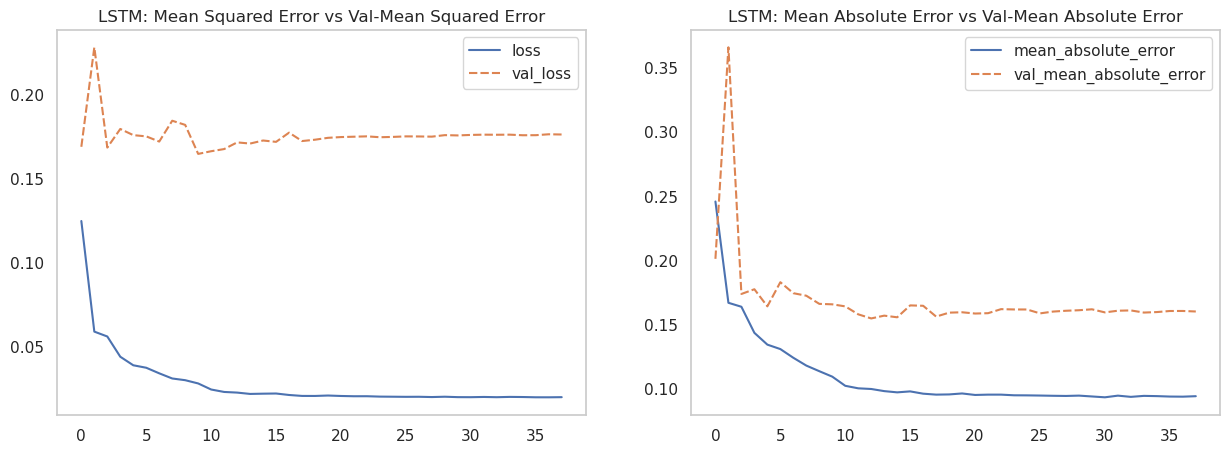

In [99]:
eval(lstm_result)

#### CNN

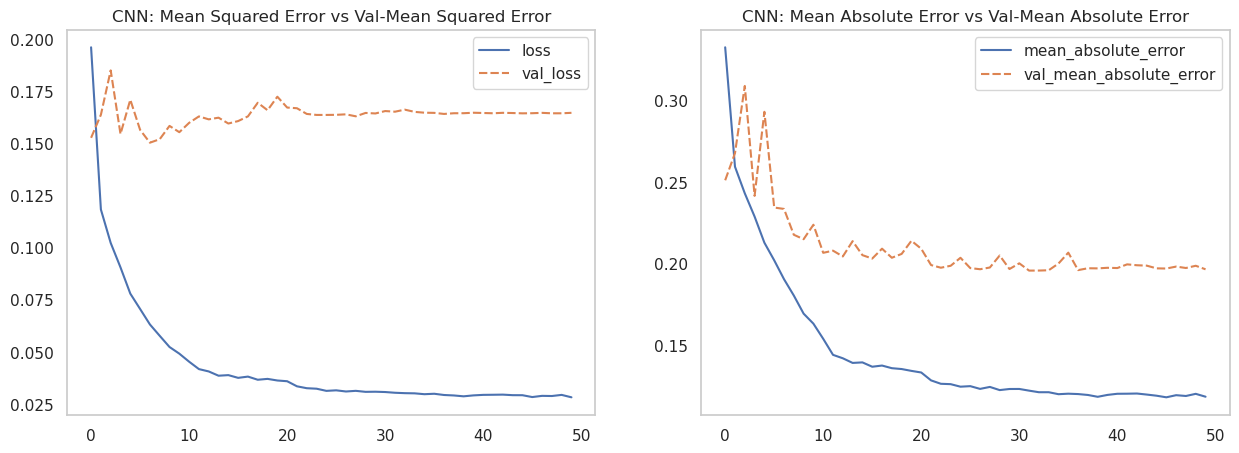

In [95]:
eval(cnn_result)

#### GRU

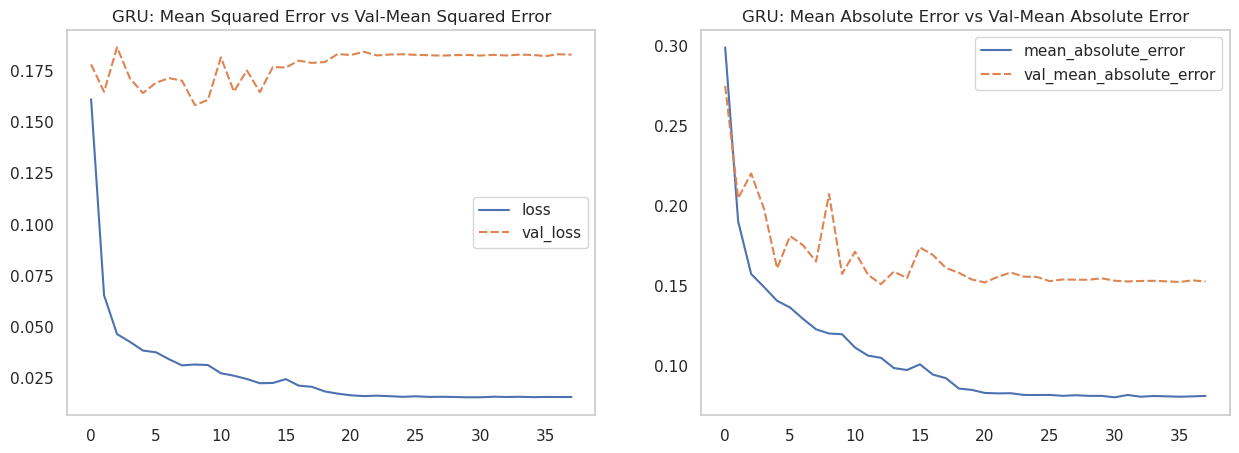

In [96]:
eval(gru_result)

#### Overall Evaluation

In [97]:
model_evaluation = pd.DataFrame(columns=['Mean Absolute Error', 'Val-Mean Absolute Error',
                                         'Mean Squared Error', 'Val-Mean Squared Error'],
                                index=['LSTM', 'CNN', 'GRU'])
# MAE
model_evaluation['Mean Absolute Error'] = [min(lstm_result.history['mean_absolute_error']),
                                          min(cnn_result.history['mean_absolute_error']),
                                          min(gru_result.history['mean_absolute_error'])]
# Val-MAE
model_evaluation['Val-Mean Absolute Error'] = [min(lstm_result.history['val_mean_absolute_error']),
                                               min(cnn_result.history['val_mean_absolute_error']),
                                               min(gru_result.history['val_mean_absolute_error'])]
# MSE
model_evaluation['Mean Squared Error'] = [min(lstm_result.history['loss']),
                                          min(cnn_result.history['loss']),
                                          min(gru_result.history['loss'])]
# Val-MSE
model_evaluation['Val-Mean Squared Error'] = [min(lstm_result.history['val_loss']), 
                                              min(cnn_result.history['val_loss']), 
                                              min(gru_result.history['val_loss'])]
model_evaluation

,Mean Absolute Error,Val-Mean Absolute Error,Mean Squared Error,Val-Mean Squared Error
LSTM,0.093151,0.154637,0.019859,0.164528
CNN,0.118164,0.195835,0.028279,0.150480
GRU,0.080361,0.150945,0.015358,0.158110


The table shows error metrics for three different machine learning models evaluated on their prediction performance:

- **LSTM (Long Short-Term Memory)**: tends to have a lower average error in its predictions, with a slight increase in error when validated.
  
- **CNN (Convolutional Neural Network)**: has higher average errors in both training and validation, indicating it might not predict as accurately as LSTM.
  
- **GRU (Gated Recurrent Unit)**: shows a low error during training but a notable increase in error on validation, similar to LSTM.
The Mean Absolute Error (MAE) values reflect the average prediction error, and the Mean Squared Error (MSE) values give more weight to larger errors. Lower values are generally better for both metrics.

Based on the results of the above analysis, the model we will deploy is the **LSTM model**, because it has a low average error, and it also has the least difference between the training and validation error.

In [2]:
model = load_model('models/lstm')
model

2023-12-05 22:01:19.556442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:01:20.038158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:01:20.038245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:01:20.042070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 22:01:20.042171: I tensorflow/compile

### LSTM Evaluation on Test Set

In [19]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print('Test set:', '\n',
      f'Mean Squared Error (Test set): {test_mse}', '\n',
      f'Mean Absolute Error (Test set): {test_mae}')

2023-12-05 22:07:56.121905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800


189/189 [==============================] - 16s 40ms/step - loss: 0.0408 - mean_absolute_error: 0.0458
Test set: 
 Mean Squared Error (Test set): 0.0408165380358696 
 Mean Absolute Error (Test set): 0.04576347395777702


The model is evaluated using the test set from the data splitting done in [Split Data](#split-data). Both MSE and MAE on the test set falls between the training and validation error which would indicate the model generalises very well in performing sentiment analysis on the test set or future data.

# **10. INSIGHT** 

**Model Deployment: Integrating the sentiment analysis model into Google's app review system can be leveraged to achieve several outcomes:**

- Quality Control: Real-time sentiment scoring can be used to flag apps with consistently poor sentiment for quality review, ensuring that the apps offered on the Play Store maintain a high standard.
- Trend Detection: Google can monitor sentiment trends for early detection of issues like bugs in recent app updates, or to identify apps that are suddenly gaining positive attention, which could then be featured or recommended.

**Strategic Actions: Providing sentiment analysis feedback to app developers can be expanded upon for further strategic initiatives:**
  
- Automated Category Insights: An automated system could provide developers with real-time analytics on how their app's sentiment compares to the average within its category, including highlighting specific aspects like customer service, usability, or functionality that may need attention.
- Benchmarking and Best Practices: Developers can receive benchmark reports comparing their apps with top-performing ones in the same category, offering insights into best practices and areas for improvement.
- Predictive Analytics for Developers: By analyzing sentiment trends, Google can offer predictive insights to developers, helping them anticipate user needs and expectations, and guiding them on when to release updates or introduce new features.
- Content Moderation Strategies: Using sentiment analysis to prioritize the review of content can help:
    - Improve Moderation Efficiency: Focus human moderators' efforts on the most critical content first, improving the efficiency of the moderation process.
    - Enhance App Safety: Quickly address apps with negative sentiments that might be related to safety or compliance issues, maintaining a safe environment for all users.
    - Refine Automated Systems: Feed sentiment analysis data into automated content moderation systems to improve their accuracy and responsiveness.